# Final project: Covid-19 vaccines Tweets Sentimental Analysis


In [24]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/FINAL PROJECT/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2021/FINAL PROJECT/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!pip install --upgrade transformers
!pip install -U kaleido

Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.6.1)
Requirement already up-to-date: kaleido in /usr/local/lib/python3.7/dist-packages (0.2.1)


## Imports


In [26]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from textblob import TextBlob
import torch
import torch.nn as nn

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from wordcloud import WordCloud 

import matplotlib.pyplot as plt


In [27]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


## Read the data

In [28]:
csv = pd.read_csv(data_path+"vaccination_all_tweets.csv").set_index("id")
csv.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
id,,,,,,,,,,,,,,,
1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [29]:
csv.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

We create now a dataframe containing only the tweet in order to perform sentimental analysis on it

In [30]:
df = pd.DataFrame([csv.text]).transpose()
df.head(10)

,text
id,
1340539111971516416,Same folks said daikon paste could treat a cyt...
1338158543359250433,While the world has been on the wrong side of ...
1337858199140118533,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
1337855739918835717,"Facts are immutable, Senator, even when you're..."
1337854064604966912,Explain to me again why we need a vaccine @Bor...
1337852648389832708,Does anyone have any useful advice/guidance fo...
1337851215875608579,it is a bit sad to claim the fame for success ...
1337850832256176136,There have not been many bright days in 2020 b...
1337850023531347969,Covid vaccine; You getting it?\n\n #CovidVacci...


We create a function now to clean the text.

In [31]:
def clean_text(text):
  text = re.sub(r'@[A-Aa-a0-9]+', '', text) # removing mentions
  text = re.sub(r'#', '', text) # removing hashtags
  text = re.sub(r'RT[\S]+', '', text) # removing RT
  text = re.sub(r'https?:\/\/\S+', '', text) # removing links
  return text

In [32]:
df['text'] = df['text'].apply(clean_text)
df.head(10)

,text
id,
1340539111971516416,Same folks said daikon paste could treat a cyt...
1338158543359250433,While the world has been on the wrong side of ...
1337858199140118533,coronavirus SputnikV AstraZeneca PfizerBioNTec...
1337855739918835717,"Facts are immutable, Senator, even when you're..."
1337854064604966912,Explain to me again why we need a vaccine @Bor...
1337852648389832708,Does anyone have any useful advice/guidance fo...
1337851215875608579,it is a bit sad to claim the fame for success ...
1337850832256176136,There have not been many bright days in 2020 b...
1337850023531347969,Covid vaccine; You getting it?\n\n CovidVaccin...


In [33]:
df.to_csv(results_path+"df_transfer.csv")

Now we are  going to compute the polarity. If polarity is negative then, the text contains negative emotions. If polarity is positive, the the text contains positive emotions.
If we get a polarity with value zero then the emotions reflected on the text are neutral.
Polarity is used to get a label for each text since on our original dataset we don't have it.

In [34]:
df['Polarity'] = [TextBlob(text).sentiment.polarity for text in df['text'].values]
df.head()

,text,Polarity
id,,
1340539111971516416,Same folks said daikon paste could treat a cyt...,0.00
1338158543359250433,While the world has been on the wrong side of ...,-0.50
1337858199140118533,coronavirus SputnikV AstraZeneca PfizerBioNTec...,0.00
1337855739918835717,"Facts are immutable, Senator, even when you're...",-0.05
1337854064604966912,Explain to me again why we need a vaccine @Bor...,0.00


In [35]:
df.loc[df['Polarity']<0, 'Sentiment'] = 'Negative'
df.loc[df['Polarity']==0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity']>0, 'Sentiment'] = 'Positive'
df.head()
print(df.shape)

(88978, 3)


In [36]:
df.head()

,text,Polarity,Sentiment
id,,,
1340539111971516416,Same folks said daikon paste could treat a cyt...,0.00,Neutral
1338158543359250433,While the world has been on the wrong side of ...,-0.50,Negative
1337858199140118533,coronavirus SputnikV AstraZeneca PfizerBioNTec...,0.00,Neutral
1337855739918835717,"Facts are immutable, Senator, even when you're...",-0.05,Negative
1337854064604966912,Explain to me again why we need a vaccine @Bor...,0.00,Neutral


Now we are going to drop the neutral sentiments because we are  interested on stronger emotions.

In [37]:
df = df[df.Sentiment != 'Neutral']
df.shape

(46819, 3)

In [38]:
df.to_csv(results_path+"df.csv")

Next, we are going to use Tokenizer() to convert text into Sequences. This war, our netowrk will be able to deal with it.


In [39]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)

## LSTM Network


In [40]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 31, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


Notice that embed_dim, lstm_out and dropout are hyperparameters and we have adjusted them by try and failure.

Once we have the model built is time to train it and test it with our data.
Let's separate into train and test.
First we are going to get the dummies for our column sentiment.

In [41]:
Y = pd.get_dummies(df['Sentiment'])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(32773, 31) (32773, 2)
(14046, 31) (14046, 2)


In [42]:
Y_train

,Negative,Positive
id,,
1380021234637762564,0,1
1350580320471556098,1,0
1380504234639171584,0,1
1397025893495709697,0,1
1377284678235746305,0,1
...,...,...
1367694863081365504,1,0
1397000937990881284,0,1
1394749701585399808,0,1


Training the network

In [43]:
'''
UNCOMMENT IF YOU WANT TO TRAIN AGAIN
batch_size = 128 
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2)'''

'\nUNCOMMENT IF YOU WANT TO TRAIN AGAIN\nbatch_size = 128 \nmodel.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2)'

In [44]:
# model.save(results_path+'lstm_model')

In [45]:
lstm = tf.keras.models.load_model(results_path+'lstm_model')

Now evaluate the model

In [46]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = lstm.evaluate(X_test, Y_test, verbose = 2, batch_size = 1)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

12546/12546 - 101s - loss: 0.1522 - accuracy: 0.9424
score: 0.15
acc: 0.94


How many has it classified correctly?

In [47]:
'''pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")'''



'pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0\nfor x in range(len(X_validate)):\n    \n    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]\n   \n    if np.argmax(result) == np.argmax(Y_validate[x]):\n        if np.argmax(Y_validate[x]) == 0:\n            neg_correct += 1\n        else:\n            pos_correct += 1\n       \n    if np.argmax(Y_validate[x]) == 0:\n        neg_cnt += 1\n    else:\n        pos_cnt += 1\n\nprint("pos_acc", pos_correct/pos_cnt*100, "%")\nprint("neg_acc", neg_correct/neg_cnt*100, "%")'

Let's see what happens with a new tweet

In [48]:
twt = ['Astra-Zeneca vaccine is a shit.']
# twt = ['Astra-Zeneca vaccine is a wonderful.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1649    4    8    9  793]]
1/1 - 16s
positive


Now we are going to analyze how sentiments have evolved over the time. For this, we are going to use only a part of the data. First of all we obtain this data by doing the prediction to the test set.

In [49]:
prediction = model.predict(X_test, batch_size=1,verbose = 2)

12546/12546 - 113s


In [50]:
prediction 

array([[0.4951585 , 0.5048415 ],
       [0.5049012 , 0.49509883],
       [0.50020885, 0.4997911 ],
       ...,
       [0.49279147, 0.5072086 ],
       [0.49776423, 0.5022358 ],
       [0.4983623 , 0.50163776]], dtype=float32)

This format is not suitable to plot the sentiments over the time. Since prediction outputs the probability for positive and negative, we are going to take the max value per row with the following function:

In [51]:
def max_sentiment(row):
    if row[0]>row[1]:
        return 1
    return -1

In [52]:
sentiment = [max_sentiment(row) for row in prediction]

In order to build our dataset that contains the data for the plot, we create a new column at Y_test:

In [53]:
Y_test["sentiment"] = sentiment

Next, we are going to merge our original dataset and Y_test to obtain the desired data structure to plot.

In [54]:
columns = ["date", "text"]
temporal = pd.merge(csv[columns], Y_test[["sentiment"]], how="inner", on="id")

In [55]:
temporal

,date,text,sentiment
id,,,
1338158543359250433,2020-12-13 16:27:13,While the world has been on the wrong side of ...,1
1337855739918835717,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",-1
1337850832256176136,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,1
1337815730486702087,2020-12-12 17:45:00,The agency also released new information for h...,1
1337776763384958976,2020-12-12 15:10:09,The trump administration failed to deliver on ...,1
...,...,...,...
1396919825172099073,2021-05-24 20:03:34,@KyhanChase Good news coming from #SputnikV ma...,-1
1396900431721340929,2021-05-24 18:46:30,No doubts left in #SputnikV. Classic #Putin @K...,-1
1396890283996979202,2021-05-24 18:06:11,#BrekingNews -\n\nThe Russian Direct Investmen...,-1


Now we have temporal containing the tweet id, the date, the text and the sentiment predicted by our network for that text.
We want to plot it, and to avoid doing changes to temporal we are going to create temporal2.

In [56]:
temporal2 = temporal.copy()

In [57]:
temporal2["date"] = temporal2.date.apply(lambda x : re.sub(r'-','',x))
temporal2["date"] = temporal2.date.apply(lambda x : re.sub(r':','',x))
temporal2["date"] = temporal2.date.apply(lambda x : re.sub(r' ','',x))
temporal2["date"] = temporal2.date.apply(lambda x : x[:8])
temporal2["date"] = pd.to_datetime(temporal2.date, format='%Y%m%d')
temporal2.head()

,date,text,sentiment
id,,,
1338158543359250433,2020-12-13,While the world has been on the wrong side of ...,1
1337855739918835717,2020-12-12,"Facts are immutable, Senator, even when you're...",-1
1337850832256176136,2020-12-12,There have not been many bright days in 2020 b...,1
1337815730486702087,2020-12-12,The agency also released new information for h...,1
1337776763384958976,2020-12-12,The trump administration failed to deliver on ...,1


We have converted the date column to a reduced format because we are going to plot the aggregated, that is, the average sentiment per day.

In [58]:
temp_avg = temporal2.groupby('date').mean()
temp_avg.reset_index(inplace=True)

In [59]:
import plotly.express as px

fig = px.line(temp_avg, x="date", y="sentiment", title='Sentiment over time')
fig.show()
fig.write_image(results_path + "sentiment_overtime.png")

In [60]:

temporal_pos = temporal2[temporal2.sentiment==1].groupby('date').sum()
temporal_pos.reset_index(inplace=True)
temporal_neg = temporal2[temporal2.sentiment==-1].groupby('date').sum()
temporal_neg.reset_index(inplace=True)
temporal_pos.head()

,date,sentiment
0,2020-12-12,3
1,2020-12-13,3
2,2020-12-14,10
3,2020-12-15,15
4,2020-12-16,13


In [61]:
temporal_neg.head()

,date,sentiment
0,2020-12-12,-4
1,2020-12-13,-7
2,2020-12-14,-8
3,2020-12-15,-10
4,2020-12-16,-16


In [62]:

import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar(name='Positive', x=temporal_pos.date, y=temporal_pos.sentiment),
    go.Bar(name='Negative', x=temporal_neg.date, y=temporal_neg.sentiment.abs())
])

fig.update_layout(barmode='group')

fig.show()
fig.write_image(results_path+"bars_juntas.png")

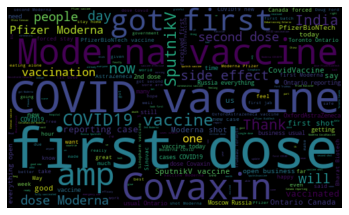

In [63]:
# wordcloud 
from wordcloud import WordCloud 

words = ' '.join([tweet for tweet in df['text']])
wordCloud = WordCloud(width = 500, height=300, random_state = 21, max_font_size=119).generate(words)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Transfer Learning

For this part, our idea was to take our original unlabeled data, pass it through a RoBERTa model extarcted from HuggingFace.com and get emotions labels such as: joy, sadness, optimism and anger.
You can find our trial at the other script called "Pseudo-Transfer Learning". For further information on what we initially wanted to do please open that script where you can find the explanation.


Due to the small time and the failed attempts to train with a RoBERTa, we have downloaded new data that already has as lables six emotions.
In the next cell, we read the data.

In [64]:
train_transfer = pd.read_csv(data_path + "emotion_data/train.txt", header=None, sep=";")
train_transfer.columns = ["text", "emotion"]
test_transfer = pd.read_csv(data_path + "emotion_data/test.txt", header=None, sep=";")
test_transfer.columns = ["text", "emotion"]
data = pd.concat((train_transfer,test_transfer), axis=0)

In [65]:
data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


To train our network we need to use Tokenize so that it understands the input:

In [66]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
x = tokenizer.texts_to_sequences(data['text'].values)
x = pad_sequences(x)
x_train = x[:train_transfer.shape[0]]
x_test = x[train_transfer.shape[0]:]



In [67]:
y_train = pd.get_dummies(train_transfer['emotion'])
y_test = pd.get_dummies(test_transfer['emotion'])
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(16000, 61) (16000, 6)
(2000, 61) (2000, 6)


Now we build our model_emotions (called LSTM_2 in the presentation). It is trained from scratch with our new data. Notice that the architecture is similar to the LSTM above. 

In [68]:
embed_dim = 128
lstm_out = 196

model_emotions = Sequential()
model_emotions.add(Embedding(max_fatures, embed_dim,input_length = x_train.shape[1]))
model_emotions.add(SpatialDropout1D(0.4))
model_emotions.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_emotions.add(Dense(6,activation='softmax'))
model_emotions.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_emotions.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 61, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 61, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1182      
Total params: 511,982
Trainable params: 511,982
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
'''
UNCOMMENT IF YOU WANT TO TRAIN AGAIN
batch_size = 1000 
model_emotions.fit(x_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)'''

'\nUNCOMMENT IF YOU WANT TO TRAIN AGAIN\nbatch_size = 1000 \nmodel_emotions.fit(x_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)'

In [70]:
# model_emotions.save(results_path+'model_emotions')

In [71]:
model_emotions = tf.keras.models.load_model(results_path + "model_emotions")

prediction = model_emotions.predict(x_test, batch_size=1,verbose = 2)

2000/2000 - 32s


In [79]:
score,acc = model_emotions.evaluate(x_test, y_test, verbose = 2, batch_size = 1)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

2000/2000 - 30s - loss: 1.0478 - accuracy: 0.6465
score: 1.05
acc: 0.65


In [73]:
model_emotions.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 61, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 61, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 6)                 1182      
Total params: 511,982
Trainable params: 511,982
Non-trainable params: 0
_________________________________________________________________


Now that we have our LSTM_2 that predicts the 6 emotions, we are going to use transfer learning with out original LSTM network to compare the performance of both.

In [74]:
lstm_emotions = tf.keras.models.load_model(results_path+'model_emotions')
lstm_pn = tf.keras.models.load_model(results_path+'lstm_model')
lstm_pn.pop()
lstm_pn.add(Dense(6, activation="softmax"))
lstm_pn.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

We have popped the last layer and added the one that we need to classify 6 emotions instead of 2 classes. Notice that the input layer has not the correct shape. Even though we have tried, it is like Keras doesn't allow us to change it so the performance is worse due to the fact that we have the wrong input shape.

In [75]:
'''
UNCOMMENT IF YOU WANT TO TRAIN AGAIN
lstm_pn.fit(x_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)'''

'\nUNCOMMENT IF YOU WANT TO TRAIN AGAIN\nlstm_pn.fit(x_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)'

In [76]:
# lstm_pn.save(results_path+'transfer_model')

In [77]:
lstm_transfer = tf.keras.models.load_model(results_path + "transfer_model")
prediction = lstm_transfer.predict(x_test, batch_size=1,verbose = 2)

2000/2000 - 32s


In [80]:
score,acc = lstm_transfer.evaluate(x_test, y_test, verbose = 2, batch_size = 1)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

2000/2000 - 31s - loss: 1.2503 - accuracy: 0.5680
score: 1.25
acc: 0.57
